# DESCRIPTION

As solvent input - its nD, alpha, beta, gamma, epsilon, phi, psi
As solute input - Minnesota features
Linear network:
    Linear(10, 512)
    ReLU
    Linear(512, 128)
    ReLU
    Linear(128, 10)
    ReLU
    Linear(10, 1)

# Importing

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Deleting charges species

In [3]:
filename = r'/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/MNSol-v2009_energies_v2.tsv'
with open(filename) as f:
    t=0
    data = pd.read_table(f)
    df1 = pd.DataFrame(data)

df2 = df1.loc[df1['Charge'].isin([0])]

In [4]:
df2.head(6)

,No.,FileHandle,SoluteName,Charge,Level1,Level2,Level3,Solvent,DeltaGsolv,type,...,S,HS,SS,P,OP,SP,Si,OSi,OS,TotalArea
0,1,0400hyd,hydrogen,0,1,1,0,water,2.33,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.747
1,2,0400hyd,hydrogen,0,1,1,0,hexadecane,1.64,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.747
2,3,0400hyd,hydrogen,0,1,1,0,octanol,1.76,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.747
3,4,0216amm,ammonia,0,1,2,0,water,-4.29,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.789
4,5,0216amm,ammonia,0,1,2,0,hexadecane,-0.93,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.789
5,6,0216amm,ammonia,0,1,2,0,benzene,-1.12,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.789


# Deleting solvent mixtures

In [5]:
filename2 = r'/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/MNSolDatabase_v2012/Solvent_properties.tsv'
with open(filename2) as f:
    data = pd.read_table(f, header=1)
    solvent_props = pd.DataFrame(data)

In [6]:
names = []
for name, count in df2['Solvent'].value_counts().items():
    row = solvent_props.loc[solvent_props['Name'] == name]
    values = np.array(row[['nD', 'alpha', 'beta', 'gamma', 'epsilon', 'phi', 'psi']])
    # print(f'{name} -> {count} -> {values.shape[0]}')
    if values.shape[0] == 0:
        print(name)
        names.append(name)
df3 = df2.loc[~df2['Solvent'].isin(names)]



octanol-water
diethylether-water
chloroform-water
heptane-water
isopropyltoluene
cyclohexane-water
benzene-water
ethylacetate-water
dichloroethane-water
carbontet-water
hexane-water
butanol-water
dibutylether-water
chlorobenzene-water
dibromoethane-water
nitrobenzene-water


CREATING X and y

In [7]:
X1 = torch.from_numpy(df3.iloc[:, 17:49].values).float()
X2 = df3['Solvent'].values
X3 = pd.DataFrame()
for s in X2:
    # print(s)
    # print(solvent_props.loc[solvent_props['Name'] == s])
    X3 = X3.append(solvent_props.loc[solvent_props['Name'] == s])
X4 = torch.from_numpy(X3.iloc[:, 2:9].values).float()
X = torch.hstack((X1, X4))
y = torch.from_numpy(df3['DeltaGsolv'].values).float()

In [8]:
X.shape

torch.Size([2411, 39])

In [9]:
X1[4]

tensor([44.8420,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, 17.9470, 31.0360,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 62.7890])

# Define linear FC network

In [10]:
class FCNet(nn.Module):
    def __init__(self, x_len = 39):
        self.x_len = x_len
        super().__init__()
        self.fc1 = nn.Linear(self.x_len, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):  # Forward will be Called from  parent __call__ method
        x = x.view(-1, self.x_len)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [61]:
np.random.seed(42)
ids = np.random.permutation(X.shape[0])
val_start = int(X.shape[0] * 0.8)
test_start = int(X.shape[0] * 0.9)

train_ids = ids[:val_start]
val_ids = ids[val_start:test_start]
test_ids = ids[test_start:]


X_train, X_val, X_test, y_train, y_val, y_test = X[train_ids], X[val_ids], X[test_ids], y[train_ids], y[val_ids], y[test_ids]

In [62]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std += (std == 0)*1.0
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

In [64]:
torch.count_nonzero(X_train)

tensor(71336)

In [66]:
X_train.flatten().shape

torch.Size([75192])

In [35]:
np.any(np.isnan(X_train.flatten()))

TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [42]:
X_train.flatten().shape

torch.Size([75192])

In [76]:
j=0
for i in torch.isnan(X_test.flatten()):
    if i:
        j+=1
        print(j)


In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCNet().to(device)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

FCNet(
  (fc1): Linear(in_features=39, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


In [70]:
from tqdm import tqdm
train_loss = []
val_loss = []
for epoch in tqdm(range(1000)):
    optimizer.zero_grad()
    # print(X_train.shape)
    y_pred = model(X_train.to(device))
    # print(y_pred)
    loss = criterion(y_pred.squeeze(), y_train.to(device))
    # print(f'loss = {loss.item}')
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        y_pred = model(X_val.to(device))
        loss = criterion(y_pred.squeeze(), y_val.to(device))
        val_loss.append(loss.item())

100%|██████████| 1000/1000 [00:04<00:00, 215.39it/s]


In [16]:
train_loss

[nan]

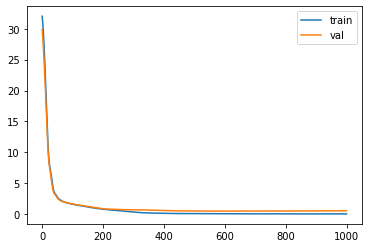

In [71]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()
plt.show()

In [83]:
with torch.no_grad():
  y_pred = model(X_test.to(device))
  test_loss = criterion(y_pred.squeeze(), y_test.to(device))
  print(test_loss)

tensor(0.4911)


# Review the results

In [87]:
y_train

tensor([ -3.4400,  -4.6100, -10.2000,  ...,  -7.2400,  -1.6300,  -3.9900])

In [84]:
df4 = df3.reset_index()

In [85]:
test_df = pd.DataFrame()
row = {'index': test_ids,
       'Solvent': df4.iloc[test_ids]['Solvent'].values,
       'Solute': df4.iloc[test_ids]['SoluteName'].values,
       'dG': y_test,
       'pred dG': y_pred[:, 0],
       'delta': abs(y_test - y_pred[:, 0])}
# print(row)
test_results = pd.DataFrame.from_dict(row)

In [86]:
test_results

,index,Solvent,Solute,dG,pred dG,delta
0,1527,carbontet,ethylamine,-2.77,-3.089693,0.319693
1,2348,water,dimethoxymethane,-2.93,-4.274761,1.344761
2,1300,hexadecane,methyl butanoate,-4.01,-3.867642,0.142358
3,2304,dichloroethane,triethylphosphate,-9.59,-10.043791,0.453791
4,1603,isopropylbenzene,butylamine,-4.06,-4.422555,0.362555
...,...,...,...,...,...,...
237,1638,carbontet,diethylamine,-4.12,-4.127951,0.007951
238,1095,benzylalcohol,acetic acid,-6.96,-6.931515,0.028485
239,1130,butanone,propanoic acid,-7.05,-7.300772,0.250772
240,1294,bromooctane,ethyl acetate,-3.97,-4.246625,0.276625
